In [1]:
from PIL import Image, ImageDraw
from IPython.display import display
import numpy as np
import cv2

import os
import math
import random
import time

import torch # pytorch의 tensor와 그와 관련된 기본 연산 등을 지원
import torch.nn as nn # 여러 딥러닝 layer와 loss, 함수 등을 클래스 형태로 지원
import torch.nn.functional as F # 여러 loss, 함수 등을 function 형태로 지원
import torch.optim as optim # 여러 optimizer를 지원
from torch.utils.data import DataLoader # 데이터 로더를 쉽게 만들 수 있도록 지원

import torchvision.transforms as T # 이미지 전처리를 지원
import torchvision.transforms.functional as TF
import torchvision.utils # 여러가지 편리한 기능을 지원 (ex. grid 이미지 만들기 등)
import torchvision.models as models # VGG, ResNet 등을 바로 로드할 수 있도록 지원
from torchvision.datasets import ImageFolder # (img, label) 형태의 데이터셋 구성을 쉽게 할 수 있도록 지원

from AffineTransform import AffineTransform
from mtcnn import detect_faces

# GPU 선택
os.environ['CUDA_VISIBLE_DEVICES']='1'

# GPU가 있을 경우 연산을 GPU에서 하고 없을 경우 CPU에서 진행
#dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev = 'cpu'

In [2]:
class ArcMarginProduct(nn.Module):
    '''
    목적 : Arc marin 을 포함한 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension
    out_features : class 개수
    '''
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        # fc의 parameter 만들기
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        '''
        Step 1. cos(theta + m) 계산하기
        '''
        # cosine : cos(theta)        
        # linear(x, W) = x * W^T = [N, in_features] * [in_features, out_features] = [N, out_features]
        # [N, out_features] / normalize-> cos dist == cos
        # F.normalize는 디폴트가 dim = 1 (줄이고자하는 dimension)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        # c^2 + s^2 = 1 
        sine = torch.sqrt((1.00000001 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # cos(theta + m) = cos(theta) * cos(m) - sin(theta) * sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        '''
        Step 2. cos(theta + m) 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cosine.size()).to(dev)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        '''
        Step 3. 이 output이 softmax -> cross entropy loss로 흘러가면 된다.
        '''
        return output

class FeatureNet_50(nn.Module):
    '''
    목적 : ResNet-50을 이용한 backbone network(feature extractor) 구현 
    
    인자 :
    feature_dim : feature의 dimension
    gray_scale : 이미지를 gray scale로 받았는지 여부
    '''
    def __init__(self, feature_dim, gray_scale=True):
        super(FeatureNet_50, self).__init__()
        # Pytorch에서 이미 구현되어 있는 resnet-50 불러오기
        resnet = models.resnet50(pretrained=True)
        
        # 이런식으로 불러온 resnet을 조건에 맞게 변경할 수 있다.
        if gray_scale:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
        # resnet의 마지막 conv block까지만 남기고 나머지 부분 잘라내기
        self.backbone = nn.Sequential(* list(resnet.children())[0:-2])
        
        # resnet의 마지막 conv block 뒤쪽으로 새로 붙을 layer 들
        self.bn_4 = nn.BatchNorm2d(2048)
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048 * 4 * 4, feature_dim)
        self.bn_5 = nn.BatchNorm1d(feature_dim)
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.bn_4(out)
        out = self.dropout(out)
        
        # FC layer를 지나기 전에는 reshape 과정이 필요하다.
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.bn_5(out)
        return out

class ArcFaceNet(nn.Module):
    '''
    ArcMarginProduct와 FeatureNet-50 을 결합한 ArcFace 모델의 구현
    '''
    def __init__(self, feature_dim, cls_num, gray_scale=True):
        super(ArcFaceNet, self).__init__()
        self.feature_net = FeatureNet_50(feature_dim, gray_scale=gray_scale)
        self.classifier = ArcMarginProduct(feature_dim, cls_num)

    # 끝까지 Forward 하여 logit을 return
    def forward(self, x, label):
        out = self.feature_net(x)
        out = self.classifier(out, label)
        return out
    
    # Feature만 return
    def extract_feature(self, x):
        out = self.feature_net(x)
        return out


In [3]:
# 각종 경로
trn_data_dir  = './data/CASIA-WebFace'
tst_data_dir  = './data/lfw'
lfw_pair_text = 'lfw_test_part.txt'
log_dir       = 'log/arcface'
weight_dir    = 'weights/arcface'

# 데이터 관련 세팅
batch_size = 16
resize = 128
crop = 128
cls_num=10575
gray_scale = True

# Hyperparameter
feature_dim = 512
lr = 0.1  # initial learning rate
lr_step = 10000
decay_ratio = 0.1
weight_decay = 5e-4

# Setting
max_epoch = 200
save_every = 10000
record_every = 1000
display_every = 1000
test_num = 6000

In [4]:
# 네트워크
net = ArcFaceNet(feature_dim=feature_dim, 
                 cls_num=cls_num, 
                 gray_scale=gray_scale).to(dev)

# optimizer 및 learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=decay_ratio)

# loss function
criterion = nn.CrossEntropyLoss()

In [5]:
def face_similarity(features, test_feature):
    sum_ = torch.mm(features, torch.t(test_feature)).squeeze()
    norm = torch.norm(features, dim=1) * torch.norm(test_feature)
    return sum_ / norm

In [6]:
def crop_image(image):
    trans_list = []        
    trans_list += [T.Grayscale(num_output_channels=1),
                   T.Resize((128, 128)),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,), std=(0.5,))]
    
    transformer = T.Compose(trans_list)
    
    cropped_image = transformer(image)
    
    return cropped_image.unsqueeze(0).to(dev)

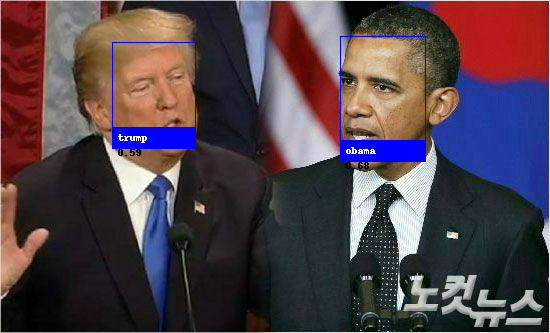

In [7]:
load_iters = 290000
ckpt_name = 'ckpt_' + str(load_iters) + '.pkl'
ckpt_path = os.path.join('weights/', ckpt_name)
# if torch.cuda.is_available():
#     net.load_state_dict(torch.load(ckpt_path))
# else:
#     net.load_state_dict(torch.load(ckpt_path,map_location='cpu'))
net.load_state_dict(torch.load(ckpt_path,map_location='cpu'))    
net.eval()
torch.no_grad()

transform = AffineTransform()

f=open("DB.txt")
tmp=f.read()
tmp=tmp.split("\n")
f.close()

known_face_names = []
for i in range(len(tmp)):
    if len(tmp[i])>0:
        data=tmp[i].split()
        known_face_names.append(data[0])
        
        cv2_im = cv2.imread(data[1])
        pil_im = Image.open(data[1])
        
        bonding_boxes, landmark_points = detect_faces(pil_im)
        aligned_images = transform.extract_image_chips(img = cv2_im, points = landmark_points, desired_size=128, padding=0.1)
        
        img=Image.fromarray(aligned_images[0])

        image_cropped = crop_image(img)
        face_feature = net.extract_feature(image_cropped.to(dev))
        
        if i==0:
            known_face_features=face_feature.clone().detach()
        else:
            known_face_features=torch.cat((known_face_features, face_feature))
        

unknown_img_file='obama_trump.jpg'
#unknown_img_file='obama_rotation.jpg'
#unknown_img_file='ChooJG.jpg'
unknown_pil_img = Image.open(unknown_img_file)
unknown_cv2_img = cv2.imread(unknown_img_file)
bounding_boxes, landmark_points = detect_faces(unknown_pil_img)
aligned_images = transform.extract_image_chips(unknown_cv2_img, points = landmark_points, desired_size=128, padding=0.1)

draw = ImageDraw.Draw(unknown_pil_img)
for i in range(len(aligned_images)):
    box=bounding_boxes[i]
    cv2_img = cv2.cvtColor(aligned_images[i],cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv2_img)
    cropped_image = crop_image(pil_img)
    unknown_face_feature=net.extract_feature(cropped_image)

    name = "Unknown"

    # Or instead, use the known face with the smallest distance to the new face
    distances = face_similarity(known_face_features, unknown_face_feature)
    #print(distances)
    best_match_index = torch.argmax(distances)
    if torch.max(distances)>0.3:
        name = known_face_names[best_match_index]

    (top, right, bottom, left) = box

    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
    draw.text((left + 6, bottom - text_height + 10), "{0:.2f}".format(torch.max(distances)), fill=(0, 0, 0, 0))
    
# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(unknown_pil_img)